# JPEG Encoder-Decoder 

based on  to https://github.com/ghallak/jpeg-python


In [11]:
#@title ▶️ Base dir setup
import os, sys

# check if hosted (Google VM) or running on local server
if 'google.colab' in sys.modules:
  #@markdown Google Drive root folder - hosted by Google VM (adapt to your local paths)
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  base_dir = 'infoMM/' #@param {type: "string"}
  base_dir  = os.path.join('/content/drive/MyDrive/', base_dir)
  #!pip install pillow  --upgrade
else:
  #@markdown Path to local folder on PC (adapt to your local paths)
  base_dir  =  'C:/Users/eumir/Desktop/Università/Anno III/Semestre 1/Informazione Multimediale/VIDEO/'  #@param {type: "string"}

# dirs
wav_dir = '../AUDIO/Audio_IN/waw/'
mp3_dir = 'data/mp3/'
img_dir = '../IMMAGINI/Immagini_IN/'
vid_dir = 'VIDEO_IN/'
out_dir = 'VIDEO_OUT/'

# move to base_dir 
os.chdir(base_dir)
print("Current dir:", os.getcwd())

Current dir: C:\Users\eumir\Desktop\Università\Anno III\Semestre 1\Informazione Multimediale\VIDEO


In [12]:
#Import the libraries

import argparse
import os
import math
import random
import numpy as np 
from scipy import fftpack
import cv2
import matplotlib.pyplot as plt
import os
import plotly.express as px
from sklearn.metrics import mean_squared_error

# Utils
- Have a look to the quantization matrix!

In [13]:
def load_quantization_table(component):
    # Quantization Table for: Photoshop - (Save For Web 080)
    # (http://www.impulseadventure.com/photo/jpeg-quantization.html)
    if component == 'lum':
        q = np.array([[2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 4, 5, 7, 9],
                      [2, 2, 2, 4, 5, 7, 9, 12],
                      [3, 3, 4, 5, 8, 10, 12, 12],
                      [4, 4, 5, 7, 10, 12, 12, 12],
                      [5, 5, 7, 9, 12, 12, 12, 12],
                      [6, 6, 9, 12, 12, 12, 12, 12]])
    elif component == 'chrom':
        q = np.array([[3, 3, 5, 9, 13, 15, 15, 15],
                      [3, 4, 6, 11, 14, 12, 12, 12],
                      [5, 6, 9, 14, 12, 12, 12, 12],
                      [9, 11, 14, 12, 12, 12, 12, 12],
                      [13, 14, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12]])
    else:
        raise ValueError((
            "component should be either 'lum' or 'chrom', "
            "but '{comp}' was found").format(comp=component))

    return q

In [14]:
def zigzag_points(rows, cols):
    # constants for directions
    UP, DOWN, RIGHT, LEFT, UP_RIGHT, DOWN_LEFT = range(6)

    # move the point in different directions
    def move(direction, point):
        return {
            UP: lambda point: (point[0] - 1, point[1]),
            DOWN: lambda point: (point[0] + 1, point[1]),
            LEFT: lambda point: (point[0], point[1] - 1),
            RIGHT: lambda point: (point[0], point[1] + 1),
            UP_RIGHT: lambda point: move(UP, move(RIGHT, point)),
            DOWN_LEFT: lambda point: move(DOWN, move(LEFT, point))
        }[direction](point)

    # return true if point is inside the block bounds
    def inbounds(point):
        return 0 <= point[0] < rows and 0 <= point[1] < cols

    # start in the top-left cell
    point = (0, 0)

    # True when moving up-right, False when moving down-left
    move_up = True

    for i in range(rows * cols):
        yield point
        if move_up:
            if inbounds(move(UP_RIGHT, point)):
                point = move(UP_RIGHT, point)
            else:
                move_up = False
                if inbounds(move(RIGHT, point)):
                    point = move(RIGHT, point)
                else:
                    point = move(DOWN, point)
        else:
            if inbounds(move(DOWN_LEFT, point)):
                point = move(DOWN_LEFT, point)
            else:
                move_up = True
                if inbounds(move(DOWN, point)):
                    point = move(DOWN, point)
                else:
                    point = move(RIGHT, point)


def bits_required(n):
    n = abs(n)
    result = 0
    while n > 0:
        n >>= 1
        result += 1
    return result

def binstr_flip(binstr):
    # check if binstr is a binary string
    if not set(binstr).issubset('01'):
        raise ValueError("binstr should have only '0's and '1's")
    return ''.join(map(lambda c: '0' if c == '1' else '1', binstr))

def uint_to_binstr(number, size):
    return bin(number)[2:][-size:].zfill(size)

def int_to_binstr(n):
    if n == 0:
        return ''

    binstr = bin(abs(n))[2:]

    # change every 0 to 1 and vice verse when n is negative
    return binstr if n > 0 else binstr_flip(binstr)

def flatten(lst):
    return [item for sublist in lst for item in sublist]

# [Huffman]

In [15]:
from queue import PriorityQueue


class HuffmanTree:

    class __Node:
        def __init__(self, value, freq, left_child, right_child):
            self.value = value
            self.freq = freq
            self.left_child = left_child
            self.right_child = right_child

        @classmethod
        def init_leaf(self, value, freq):
            return self(value, freq, None, None)

        @classmethod
        def init_node(self, left_child, right_child):
            freq = left_child.freq + right_child.freq
            return self(None, freq, left_child, right_child)

        def is_leaf(self):
            return self.value is not None

        def __eq__(self, other):
            stup = self.value, self.freq, self.left_child, self.right_child
            otup = other.value, other.freq, other.left_child, other.right_child
            return stup == otup

        def __nq__(self, other):
            return not (self == other)

        def __lt__(self, other):
            return self.freq < other.freq

        def __le__(self, other):
            return self.freq < other.freq or self.freq == other.freq

        def __gt__(self, other):
            return not (self <= other)

        def __ge__(self, other):
            return not (self < other)

    def __init__(self, arr):
        q = PriorityQueue()

        # calculate frequencies and insert them into a priority queue
        for val, freq in self.__calc_freq(arr).items():
            q.put(self.__Node.init_leaf(val, freq))

        while q.qsize() >= 2:
            u = q.get()
            v = q.get()

            q.put(self.__Node.init_node(u, v))

        self.__root = q.get()

        # dictionaries to store huffman table
        self.__value_to_bitstring = dict()

    def value_to_bitstring_table(self):
        if len(self.__value_to_bitstring.keys()) == 0:
            self.__create_huffman_table()
        return self.__value_to_bitstring

    def __create_huffman_table(self):
        def tree_traverse(current_node, bitstring=''):
            if current_node is None:
                return
            if current_node.is_leaf():
                self.__value_to_bitstring[current_node.value] = bitstring
                return
            tree_traverse(current_node.left_child, bitstring + '0')
            tree_traverse(current_node.right_child, bitstring + '1')

        tree_traverse(self.__root)

    def __calc_freq(self, arr):
        freq_dict = dict()
        for elem in arr:
            if elem in freq_dict:
                freq_dict[elem] += 1
            else:
                freq_dict[elem] = 1
        return freq_dict

# Load an image

In [16]:
img = cv2.imread( img_dir + 'acque1.tif') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# show image
fig = px.imshow(img)
fig.show()

# Utils 2
 
* Pay attention to how the quantization is obtained

In [17]:
def quantize(block, component):
    q = load_quantization_table(component)
    return (block / q).round().astype(np.int32)

def quantize2(block, component, param):
    q = load_quantization_table(component) * param
    return (block / q).round().astype(np.int32)

In [18]:
def block_to_zigzag(block):
    return np.array([block[point] for point in zigzag_points(*block.shape)])

def dct_2d(image):
    return fftpack.dct(fftpack.dct(image.T, norm='ortho').T, norm='ortho')

def run_length_encode(arr):
    # determine where the sequence is ending prematurely
    last_nonzero = -1
    for i, elem in enumerate(arr):
        if elem != 0:
            last_nonzero = i

    # each symbol is a (RUNLENGTH, SIZE) tuple
    symbols = []

    # values are binary representations of array elements using SIZE bits
    values = []

    run_length = 0

    for i, elem in enumerate(arr):
        if i > last_nonzero:
            symbols.append((0, 0))
            values.append(int_to_binstr(0))
            break
        elif elem == 0 and run_length < 15:
            run_length += 1
        else:
            size = bits_required(elem)
            symbols.append((run_length, size))
            values.append(int_to_binstr(elem))
            run_length = 0
    return symbols, values

def write_to_file(filepath, dc, ac, blocks_count, tables):
    try:
        f = open(filepath, 'w')
    except FileNotFoundError as e:
        raise FileNotFoundError(
                "No such directory: {}".format(
                    os.path.dirname(filepath))) from e

    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:

        # 16 bits for 'table_size'
        f.write(uint_to_binstr(len(tables[table_name]), 16))

        for key, value in tables[table_name].items():
            if table_name in {'dc_y', 'dc_c'}:
                # 4 bits for the 'category'
                # 4 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key, 4))
                f.write(uint_to_binstr(len(value), 4))
                f.write(value)
            else:
                # 4 bits for 'run_length'
                # 4 bits for 'size'
                # 8 bits for 'code_length'
                # 'code_length' bits for 'huffman_code'
                f.write(uint_to_binstr(key[0], 4))
                f.write(uint_to_binstr(key[1], 4))
                f.write(uint_to_binstr(len(value), 8))
                f.write(value)

    # 32 bits for 'blocks_count'
    f.write(uint_to_binstr(blocks_count, 32))

    for b in range(blocks_count):
        for c in range(3):
            category = bits_required(dc[b, c])
            symbols, values = run_length_encode(ac[b, :, c])

            dc_table = tables['dc_y'] if c == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if c == 0 else tables['ac_c']

            f.write(dc_table[category])
            f.write(int_to_binstr(dc[b, c]))

            for i in range(len(symbols)):
                f.write(ac_table[tuple(symbols[i])])
                f.write(values[i])
    f.close()


# Utils decoder 

* Pay attention to how de-quantization is obtained

In [19]:
def dequantize(block, component):
    q = load_quantization_table(component)
    return block * q

def dequantize2(block, component, param):
    q = load_quantization_table(component) / param
    return block * q

In [20]:
class JPEGFileReader:
    TABLE_SIZE_BITS = 16
    BLOCKS_COUNT_BITS = 32

    DC_CODE_LENGTH_BITS = 4
    CATEGORY_BITS = 4

    AC_CODE_LENGTH_BITS = 8
    RUN_LENGTH_BITS = 4
    SIZE_BITS = 4

    def __init__(self, filepath):
        self.__file = open(filepath, 'r')

    def read_int(self, size):
        if size == 0:
            return 0

        # the most significant bit indicates the sign of the number
        bin_num = self.__read_str(size)
        if bin_num[0] == '1':
            return self.__int2(bin_num)
        else:
            return self.__int2(binstr_flip(bin_num)) * -1

    def read_dc_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            category = self.__read_uint(self.CATEGORY_BITS)
            code_length = self.__read_uint(self.DC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = category
        return table

    def read_ac_table(self):
        table = dict()

        table_size = self.__read_uint(self.TABLE_SIZE_BITS)
        for _ in range(table_size):
            run_length = self.__read_uint(self.RUN_LENGTH_BITS)
            size = self.__read_uint(self.SIZE_BITS)
            code_length = self.__read_uint(self.AC_CODE_LENGTH_BITS)
            code = self.__read_str(code_length)
            table[code] = (run_length, size)
        return table

    def read_blocks_count(self):
        return self.__read_uint(self.BLOCKS_COUNT_BITS)

    def read_huffman_code(self, table):
        prefix = ''
        # TODO: break the loop if __read_char is not returing new char
        while prefix not in table:
            prefix += self.__read_char()
        return table[prefix]

    def __read_uint(self, size):
        if size <= 0:
            raise ValueError("size of unsigned int should be greater than 0")
        return self.__int2(self.__read_str(size))

    def __read_str(self, length):
        return self.__file.read(length)

    def __read_char(self):
        return self.__read_str(1)

    def __int2(self, bin_num):
        return int(bin_num, 2)


def read_image_file(filepath):
    reader = JPEGFileReader(filepath)

    tables = dict()
    for table_name in ['dc_y', 'ac_y', 'dc_c', 'ac_c']:
        if 'dc' in table_name:
            tables[table_name] = reader.read_dc_table()
        else:
            tables[table_name] = reader.read_ac_table()

    blocks_count = reader.read_blocks_count()

    dc = np.empty((blocks_count, 3), dtype=np.int32)
    ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

    for block_index in range(blocks_count):
        for component in range(3):
            dc_table = tables['dc_y'] if component == 0 else tables['dc_c']
            ac_table = tables['ac_y'] if component == 0 else tables['ac_c']

            category = reader.read_huffman_code(dc_table)
            dc[block_index, component] = reader.read_int(category)

            cells_count = 0

            # TODO: try to make reading AC coefficients better
            while cells_count < 63:
                run_length, size = reader.read_huffman_code(ac_table)

                if (run_length, size) == (0, 0):
                    while cells_count < 63:
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                else:
                    for i in range(run_length):
                        ac[block_index, cells_count, component] = 0
                        cells_count += 1
                    if size == 0:
                        ac[block_index, cells_count, component] = 0
                    else:
                        value = reader.read_int(size)
                        ac[block_index, cells_count, component] = value
                    cells_count += 1

    return dc, ac, tables, blocks_count


def zigzag_to_block(zigzag):
    # assuming that the width and the height of the block are equal
    rows = cols = int(math.sqrt(len(zigzag)))

    if rows * cols != len(zigzag):
        raise ValueError("length of zigzag should be a perfect square")

    block = np.empty((rows, cols), np.int32)

    for i, point in enumerate(zigzag_points(rows, cols)):
        block[point] = zigzag[i]

    return block


def idct_2d(image):
    return fftpack.idct(fftpack.idct(image.T, norm='ortho').T, norm='ortho')

# * Encoder

given a RGB image, we are now ready to apply the Jpeg encoder:

In [21]:
# (1) Convert RGB 2 YCrCb
ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
rows, cols = ycrcb.shape[0], ycrcb.shape[1]

# - Guarantee the image dimensions are multiple of 8, to allow the image blocking
rmRows = rows % 8
rmCols = cols % 8
dim = (cols - rmCols, rows - rmRows)
ycrcb = cv2.resize(ycrcb, dim , interpolation = cv2.INTER_CUBIC)

# - Cast the data to uint8
npmat = np.array(ycrcb, dtype=np.uint8)
rows, cols = npmat.shape[0], npmat.shape[1]

# - Check again the image dimension so that block size: 8x8
if rows % 8 == cols % 8 == 0:
    blocks_count = rows // 8 * cols // 8
else:
    raise ValueError(("the width and height of the image "
                      "should both be mutiples of 8"))

# - Prepare the structures to encode the image 
# dc is the top-left cell of the block, ac are all the other cells
dc = np.empty((blocks_count, 3), dtype=np.int32)
ac = np.empty((blocks_count, 63, 3), dtype=np.int32)


# Encode a single block

To understand how the encoder work, it is useful to follow the process on a single block

In [22]:
block_per_line = rows//8   # nb. of blocks per line
block_per_cols = cols//8   # nb. of blocks per colomn
print("Block per line: "+  str(block_per_line))
print("Block per column: "+  str(block_per_cols))

# Choose a block
k = 0   # select the layer to compress: 0:Y, 1:Cr, 2:Cb
i = random.randint(0,block_per_line-1) #(block_per_line//8) #6   # select the block row to compress 0<= i <= block_per_line
j = random.randint(0,block_per_cols-1) #(block_per_cols//8) #10  # select the block col to compress 0<= i <= block_per_cols
print (i,j)

# (2) Select a block 
block = npmat[i:i+8, j:j+8, k]
originalBlock= block
print("\n Block: \n"+ str(block)) 

# (3) Shift the block value so that they are centered in zero
block = block.astype(float)
block = block - 128
print("\n Shifted block: \n"+ str(block)) 



Block per line: 58
Block per column: 93
23 0

 Block: 
[[63 62 59 57 59 62 65 65]
 [61 62 64 63 65 60 63 64]
 [67 66 67 68 68 61 61 62]
 [72 72 70 70 68 64 64 64]
 [74 76 72 69 68 69 68 65]
 [75 78 73 70 70 71 70 66]
 [72 74 75 76 75 71 70 68]
 [74 73 75 77 78 71 69 69]]

 Shifted block: 
[[-65. -66. -69. -71. -69. -66. -63. -63.]
 [-67. -66. -64. -65. -63. -68. -65. -64.]
 [-61. -62. -61. -60. -60. -67. -67. -66.]
 [-56. -56. -58. -58. -60. -64. -64. -64.]
 [-54. -52. -56. -59. -60. -59. -60. -63.]
 [-53. -50. -55. -58. -58. -57. -58. -62.]
 [-56. -54. -53. -52. -53. -57. -58. -60.]
 [-54. -55. -53. -51. -50. -57. -59. -59.]]


In [23]:
# (4) Convert the block using the DCT
dct_matrix = dct_2d(block)
print("DCT transform: \n ")

np.set_printoptions(precision=2)
print(dct_matrix)


DCT transform: 
 
[[-4.79e+02  1.34e+01 -2.66e+00 -4.03e-01  6.25e-01 -1.53e+00 -2.82e+00
   1.96e+00]
 [-3.37e+01 -7.06e+00  6.66e+00 -1.07e+00  5.24e-01  1.34e-01  2.34e-01
   9.87e-01]
 [-5.09e+00 -9.38e+00 -1.12e+00 -2.25e-01  2.20e+00  2.57e-01  7.01e-01
   1.50e+00]
 [-2.33e-01 -2.01e+00  7.84e+00  3.01e+00 -7.08e+00 -2.53e-01 -3.23e-01
  -1.91e+00]
 [ 8.75e-01  4.59e-01  3.60e+00  1.64e+00 -3.75e-01  2.58e-01  5.36e-01
  -9.81e-01]
 [ 1.39e-01  4.96e-01  2.16e-01 -3.37e-02  7.40e-01  7.23e-01 -1.29e-01
  -9.10e-01]
 [-1.93e-01  1.87e+00  1.95e+00  2.15e+00 -2.36e-01 -3.68e-01  1.19e-01
  -4.61e-01]
 [-3.26e-01 -2.94e-01 -8.52e-01  2.62e-01  5.53e-02  3.44e-01  4.30e-01
  -1.65e-01]]


In [24]:
# (5) Ready for quantization, dividing the dct coefficients with the quantizer matrix
quant_matrix = quantize(dct_matrix, 'lum' if k == 0 else 'chrom')
print(quant_matrix)

[[-240    7   -1    0    0    0   -1    0]
 [ -17   -4    3   -1    0    0    0    0]
 [  -3   -5   -1    0    1    0    0    0]
 [   0   -1    4    1   -1    0    0    0]
 [   0    0    1    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]]


In [25]:
# (6) Linearize the block reading the values in a zigzag way
zz = block_to_zigzag(quant_matrix)
print(zz)

[-240    7  -17   -3   -4   -1    0    3   -5    0    0   -1   -1   -1
    0    0    0    0    4    0    0    0    0    1    1    1    0   -1
    0    0    0   -1    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [26]:
# (7) store the dc and ac values separately

dc_single_block = zz[0]
ac_single_block = zz[1:]
print("dc:"+ str(dc_single_block))
print("ac:"+ str(ac_single_block))

dc:-240
ac:[  7 -17  -3  -4  -1   0   3  -5   0   0  -1  -1  -1   0   0   0   0   4
   0   0   0   0   1   1   1   0  -1   0   0   0  -1   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0]


# Decode a single block

In [27]:
# (1) join the DC and AC values in a unique vector
c= k
zigzag = [dc_single_block] + list(ac_single_block)
print("\n Zigzag: "+ str(zigzag))

# (2) go back to the square matrice 8x8
quant_matrix = zigzag_to_block(zigzag)
print("\n Squared quantized matrix: \n"+ str(quant_matrix))

# (3) Dequantize the coefficient
dct_matrix = dequantize(quant_matrix, 'lum' if c == 0 else 'chrom')
print("\n Dequantized matrix: \n"+ str(dct_matrix))

# (4) Apply the inverse dct
block = idct_2d(dct_matrix)
block = np.uint8(block)
print("\n Shifted reconstructed Ycrcb (): \n"+ str(block))

# (5) Shift back to the original dynalic range
npmat = block +128
print ("\n Reconstructed block: \n"+ str(npmat))
print ("\n Original block (for comparison): \n"+ str(originalBlock))


 Zigzag: [-240, 7, -17, -3, -4, -1, 0, 3, -5, 0, 0, -1, -1, -1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 1, 1, 0, -1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

 Squared quantized matrix: 
[[-240    7   -1    0    0    0   -1    0]
 [ -17   -4    3   -1    0    0    0    0]
 [  -3   -5   -1    0    1    0    0    0]
 [   0   -1    4    1   -1    0    0    0]
 [   0    0    1    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]]

 Dequantized matrix: 
[[-480   14   -2    0    0    0   -5    0]
 [ -34   -8    6   -2    0    0    0    0]
 [  -6  -10   -2    0    4    0    0    0]
 [   0   -2    8    4   -5    0    0    0]
 [   0    0    4    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0]]

 Shifted reconstructed Ycrcb (): 
[[190 

# Exercise 1
Given the original block "originalBlock" and the reconstructed one "npmat" compute the RMSE (Hint use the function mean_squared_error already imported from sklearn.metrics)

In [28]:
#TODO

RMSE = mean_squared_error(originalBlock, npmat)
print(RMSE)

0.96875


# Exercise 2:

When we save an image as a JPEG, we are asked about the quality we want. This is obtained multiplying the quantization matrix by a factor: if greater than 1, we will truncate more (higher compression, but lower quality), if we set the factor less than 1, we compress less preserving the image quality.

=> Modify the code in order to obtain a parametric compression. Does the RMSE change according to the quantization factor? Try with factor= 3

**HINT**: You should define two new  functions, say,  `quantize2` (similar to  `quantize`  in [Utils2]) and `dequantize2` (similar to `dequantize` in [Utils decoder]) and call them properly


# Encode the whole image

In [29]:
def jpeg_encoder(img, factor): 

  # (1) Convert RGB 2 YCrCb
  ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
  rows, cols = ycrcb.shape[0], ycrcb.shape[1]

  # - Guarantee the image dimensions are multiple of 8, to allow the image blocking
  rmRows = rows % 8
  rmCols = cols % 8
  dim = (cols - rmCols, rows - rmRows)
  ycrcb = cv2.resize(ycrcb, dim , interpolation = cv2.INTER_CUBIC)

  # - Cast the data to uint8
  npmat = np.array(ycrcb, dtype=np.uint8)
  rows, cols = npmat.shape[0], npmat.shape[1]

  # - Check again the image dimension so that block size: 8x8
  if rows % 8 == cols % 8 == 0:
      blocks_count = rows // 8 * cols // 8
  else:
      raise ValueError(("the width and height of the image "
                        "should both be mutiples of 8"))

  # - Prepare the structures to encode the image 
  # dc is the top-left cell of the block, ac are all the other cells
  dc = np.empty((blocks_count, 3), dtype=np.int32)
  ac = np.empty((blocks_count, 63, 3), dtype=np.int32)

  block_index= -1
  
  for i in range(0, rows, 8):
    #print("i: "+ str(i))
    for j in range(0, cols, 8):
        #print("j: "+ str(j))
        block_index += 1
        #print("block_index: "+ str(block_index))
         
        for k in range(3):
            # split 8x8 block and center the data range on zero
            # [0, 255] --> [-128, 127]
            block = npmat[i:i+8, j:j+8, k] - 128

            dct_matrix = dct_2d(block)
            quant_matrix = quantize2(dct_matrix,
                                    'lum' if k == 0 else 'chrom', factor)
            zz = block_to_zigzag(quant_matrix)

            dc[block_index, k] = zz[0]
            ac[block_index, :, k] = zz[1:]
 
  H_DC_Y = HuffmanTree(np.vectorize(bits_required)(dc[:, 0]))
  H_DC_C = HuffmanTree(np.vectorize(bits_required)(dc[:, 1:].flat))
  H_AC_Y = HuffmanTree(
          flatten(run_length_encode(ac[i, :, 0])[0]
                  for i in range(blocks_count)))
  H_AC_C = HuffmanTree(
          flatten(run_length_encode(ac[i, :, j])[0]
                  for i in range(blocks_count) for j in [1, 2]))

  tables = {'dc_y': H_DC_Y.value_to_bitstring_table(),
            'ac_y': H_AC_Y.value_to_bitstring_table(),
            'dc_c': H_DC_C.value_to_bitstring_table(),
            'ac_c': H_AC_C.value_to_bitstring_table()}

  return (dc, ac, blocks_count, tables, factor)

In [30]:
(dc, ac, blocks_count, tables, factor) = jpeg_encoder(img, 2)

output_file =  os.path.join(out_dir, 'acque1_COMPR')
write_to_file(output_file, dc, ac, blocks_count, tables)

# Decode the whole image

In [31]:
def jpeg_decoder(dc, ac, blocks_count, tables, factor, filename):

  dc, ac, tables, blocks_count = read_image_file(filename)

  # assuming that the block is a 8x8 square
  block_side = 8
  block_per_line = rows//8  #24
  block_per_cols = cols//8  #35
  
  npmat = np.empty((rows,cols, 3), dtype=np.uint8)
  npmat.shape

  for block_index in range(blocks_count): #block_index=782
      i = block_index // block_per_cols * block_side
      j = block_index % block_per_cols * block_side
      #print(block_index, i,j)
      for c in range(3):
          zigzag = [dc[block_index, c]] + list(ac[block_index, :, c])
        
          quant_matrix = zigzag_to_block(zigzag)
          dct_matrix = dequantize2(quant_matrix, 'lum' if c == 0 else 'chrom', factor)
          block = idct_2d(dct_matrix)
          npmat[i:i+8, j:j+8, c] = block + 128
    
  rgbImg = cv2.cvtColor(npmat, cv2.COLOR_YCrCb2RGB)     
  return rgbImg 

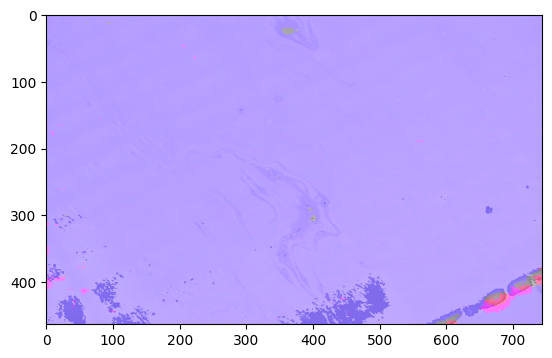

In [32]:
rgbImg = jpeg_decoder(dc, ac, blocks_count, tables, factor,output_file)
plt.imshow(rgbImg)